## Recurrent Neural Networks (RNNs) for the Regression Problem

In this notebook, we build a Recurrent Neural Networks (RNNs) using GloVe word embeddings, to predict the __log_votes__ field of our review dataset.

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)

__Important note:__ One big distinction betweeen the regular neural networks and RNNs is that RNNs work with sequential data. In our case, RNNs will help us with the text field. If we also want to consider other fields such as time, rating, verified, etc. , we need to use the regular neural networks and connect it to the RNN network.

In [1]:
import re
from collections import Counter
import d2l
from sklearn.model_selection import train_test_split
import mxnet as mx
from mxnet import gluon, autograd, np, npx
from mxnet.gluon import nn, rnn

npx.set_np()

### 1. Reading the dataset

Let's read the dataset below and fill-in the reviewText field. We will use this field as input to our ML model.

In [2]:
import pandas as pd

df = pd.read_csv('../../DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv')

Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [3]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


### 2. Exploratory Data Analysis and Missing Value Imputation

Let's look at the range and distribution of log_votes

In [4]:
df["log_votes"].min()

0.0

In [5]:
maximum = df["log_votes"].max()
maximum

7.799753318287247

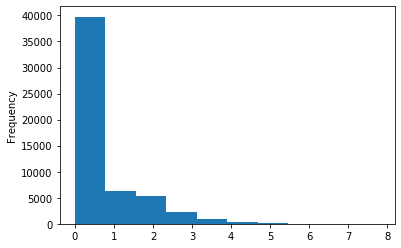

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [7]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


We will only consider the reviewText field. Let's fill-in the missing values for that below. We will just use the placeholder "Missing" here.

In [8]:
df["reviewText"].fillna("Missing", inplace=True)

In [9]:
## length of dataset: 55000
df.shape

(55000, 6)

### 3. Text processing-cleaning
Next, we will clean the text. We will remove leading/train white space, extra space and html tags. Recurrent neural networks usually __DON'T__ need text processing work further than simple text cleaning. Stemming and lemmatization can introduce some errors that will cause our model to skip those words completely. 

In [10]:
# Some string preprocessing
def clean_str(text):
    text = text.lower().strip() # Remove leading/trailing whitespace
    text = re.sub('\s+', ' ', text) # Remove extra space and tabs
    text = re.compile('<.*?>').sub('', text) # Remove HTML tags/markups:
    return text

Next, we are going to process all of the words in the reviews, count the number of occurences of each word, and then index the words in descending order with respect to how many times this occur. This is a necessary input to help us encode the words in the reviews so that they can be understood by a machine.

In [11]:
#This creates a dictionary of the words and their counts

word_counter = Counter()
def create_count(sentiments):
    for line in sentiments:
        for word in (clean_str(line)).split():
            if word not in word_counter.keys():               
                word_counter[word] = 1
            else:
                word_counter[word] += 1

#This assigns a unique a number for each word (sorted by descending order 
#based on the frequency of occurrence)and returns a word_dict

def create_word_index():
    idx = 1
    word_dict = {}
    for word in word_counter.most_common():
        word_dict[word[0]] = idx
        idx+=1
    return word_dict
    
#Here we combine all of the reviews into one dataset and create a word
#dictionary using this entire dataset
create_count(df["reviewText"].tolist())
word_dict = create_word_index()

#This creates a reverse index from a number to the word 
idx2word = {v: k for k, v in word_dict.items()}

Next we create a set of helper functions that (1) encode words into a sequence of numbers, (2) decode a sequence of numbers back into words, and (3) truncate and pad the input data to ensure they are of equal length and thereby enable easier processing.  

In [12]:
#This helper function creates a encoded sentences by assigning the unique 
#id from word_dict to the words in the input text
def encoded_sentences(input_file,word_dict):
    output_string = []
    for line in input_file:
        output_line = []
        for word in (clean_str(line)).split():
            if word in word_dict:
                output_line.append(word_dict[word])
        output_string.append(output_line)
    return output_string

#This helper function decodes encoded sentences
def decode_sentences(input_file,word_dict):
    output_string = []
    for line in input_file:
        output_line = ''
        for idx in line:
            output_line += idx2word[idx] + ' '
        output_string.append(output_line)
    return output_string

#This helper function pads the sequences to maxlen.
#If the sentence is greater than maxlen, it truncates the sentence.
#If the sentence is less than 50, it pads with value 0.
def pad_sequences(sentences,maxlen=50,value=0):
    padded_sentences = []
    for sen in sentences:
        new_sentence = []
        if(len(sen) > maxlen):
            new_sentence = sen[:maxlen]
            padded_sentences.append(new_sentence)
        else:
            num_padding = maxlen - len(sen)
            new_sentence = np.append(sen,[value] * num_padding)
            padded_sentences.append(new_sentence)
    return padded_sentences

Next we are going to encode all of the reviewText using the word dictionary created. In addition, we are going to cap the size of the tracked vocabulary size - meaning any word that is outside of the tracked range will be encoded with the last position. This is performance versus accuracy consideration - a larger tracked vocabulary will lead to more accurary but will have performance considerations because it requires a longer training process.

In [13]:
# Let's encode sentences
encoded_texts = encoded_sentences(df["reviewText"].tolist(), word_dict)

#Here we set the total num of words to be tracked
vocab_size = 5000 

#Any word outside of the tracked range will be encoded with last position.
# t_data = [np.array([i if i<(vocab_size-1) else (vocab_size-1) for i in s]) for s in encoded_texts]
all_labels = df["log_votes"].tolist()

In [14]:
encoded_texts[0]

[1095, 15, 10, 42, 751, 449, 4, 102, 101, 117, 1147, 15, 5, 10733, 12853]

In [15]:
# Let's print the first sentence
# We have 4999 for words outside range of 5000 words

# t_data[0]

array([1.095e+03, 1.500e+01, 1.000e+01, 4.200e+01, 7.510e+02, 4.490e+02,
       4.000e+00, 1.020e+02, 1.010e+02, 1.170e+02, 1.147e+03, 1.500e+01,
       5.000e+00, 4.999e+03, 4.999e+03])

### 4. Using pre-trained GloVe Word Embeddings:

In this example, we will use GloVe word vectors. The following code shows how to get the word vectors and create an embedding dictionary with them. The dictionary maps the words to their word vectors. The file is downloaded from here: https://nlp.stanford.edu/projects/glove/

Below, we first create a mapper for the word vectors (word->vector) with the __load_glove_index()__ function. Later, __create_emb()__ creates an embedding matrix. Each row corresponds to a word. For our vocabulary size of 5000 and 300 word vector dimension, this gives a matrix of 5000 rows and  300 columns.

# D2L embedding

In [16]:
import d2l

In [25]:
# This separates 15% of the entire dataset into test dataset.
X_train, X_test, y_train, y_test = train_test_split(df["reviewText"], all_labels, test_size=0.15, random_state=42)

In [26]:
print(X_train.shape, len(y_test))
X_train[0]

(46750,) 8250


'Stuck with this at work, slow and we still got hit with a ransomware attack.'

In [27]:
def load_data(X_train, X_test, y_train, y_test, num_steps=50):
    ## num_steps=50 trim the sentence after the 50th word
    
    train_tokens = d2l.tokenize(X_train, token='word')
    test_tokens = d2l.tokenize(X_test, token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    
    ## convert to ndarray
    train_features = np.array([d2l.trim_pad(vocab[line], num_steps, vocab.unk)
                               for line in train_tokens], dtype=np.float32)
    test_features = np.array([d2l.trim_pad(vocab[line], num_steps, vocab.unk)
                              for line in test_tokens], dtype=np.float32)  ## l2_loss does not accept float64
    y_train = np.array(y_train, dtype=np.float32).reshape(-1, 1)
    y_test = np.array(y_test, dtype=np.float32).reshape(-1, 1)

    return train_features, test_features, y_train, y_test, vocab

truncate_word_after_max = 50
train_features, test_features, train_labels, test_labels, vocab = \
    load_data(X_train, X_test, y_train, y_test, truncate_word_after_max)

In [30]:
import time
start = time.time()

from mxnet.contrib import text
glove_embedding = text.embedding.create('glove', pretrained_file_name='glove.6B.300d.txt')
embedding_matrix = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embedding_matrix.shape

end = time.time()
print(end - start)

42.35235381126404


In [49]:
context, num_hidden = mx.cpu(), 100

In [106]:
model = nn.Sequential()
model.add(nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1]),        # Embedding layer
          # Recurrent layer: where T, N and C stand for sequence length, 
          # batch size, and feature dimensions respectively.
          rnn.RNN(num_hidden, layout = 'NTC'),        
          nn.Dense(1, activation='relu')              # Output layer
         )

model.collect_params().initialize(mx.init.Xavier(), ctx=context)
model[0].weight.set_data(embedding_matrix)
model[0].collect_params().setattr('grad_req', 'null')
model


# class BiRNN(nn.Block):
#     def __init__(self, vocab_size, embed_size, num_hiddens,
#                  num_layers, **kwargs):
#         super(BiRNN, self).__init__(**kwargs)
#         self.embedding = nn.Embedding(vocab_size, embed_size)

#         self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
#                                 bidirectional=True, input_size=embed_size)
#         self.decoder = nn.Dense(1)

#     def forward(self, inputs):
#         # The shape of inputs is (batch size, number of words). Because LSTM
#         # needs to use sequence as the first dimension, the input is
#         # transformed and the word feature is then extracted. The output shape
#         # is (number of words, batch size, word vector dimension).
#         embeddings = self.embedding(inputs.T)
#         # Since the input (embeddings) is the only argument passed into
#         # rnn.LSTM, it only returns the hidden states of the last hidden layer
#         # at different timestep (outputs). The shape of outputs is
#         # (number of words, batch size, 2 * number of hidden units).
#         outputs = self.encoder(embeddings)
#         # Concatenate the hidden states of the initial timestep and final
#         # timestep to use as the input of the fully connected layer. Its
#         # shape is (batch size, 4 * number of hidden units)
#         print(outputs.shape)
#         encoding = np.concatenate((outputs[0], outputs[-1]), axis= -1)
#         print(encoding.shape)
#         outs = self.decoder(encoding)
#         return outs
    
# model = BiRNN(embedding_matrix.shape[0], embedding_matrix.shape[1], 100, 2)    
# # model = BiRNN(vocab_size=embedding_matrix.shape[0], 
# #             embed_size=embedding_matrix.shape[1], 
# #             num_hiddens=100, num_layers=2)
# model.initialize(mx.init.Xavier(), ctx=context)

Sequential(
  (0): Embedding(23421 -> 300, float32)
  (1): RNN(-1 -> 100, NTC)
  (2): Dense(-1 -> 1, Activation(relu))
)

In [107]:
def log_rmse(net, features, labels, maximum=maximum):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
#     out = [net(X) for X in features]
    clipped_preds = np.clip(out, 1, maximum)
    return np.sqrt(2 * l2_loss(np.log(clipped_preds), np.log(labels)).mean())

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, batch_size):
    l2_loss = gluon.loss.L2Loss() 
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size)
    # The SGD optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                            {'learning_rate': learning_rate})
    for epoch in range(num_epochs):
        train_ls, test_ls = 0, 0
        for X, y in train_iter:
#             print(X.shape) # (64, 50)
            with autograd.record():
                out = net(X)
                l = l2_loss(out, y)
                
                l.backward()
            trainer.step(batch_size)
            train_ls += l.sum()
#         train_ls.append(log_rmse(net, train_features, train_labels))
        
        
        for test_X, test_y in test_iter:
            test_ls += l2_loss(net(test_X), test_y).sum()
            
        # Let's take the average losses
        training_loss = train_ls / len(train_labels)
        val_loss = test_ls / len(test_labels)
        print("Epoch %s. Train_loss (mse) %s Validation_loss (mse) %s" % (epoch, training_loss, val_loss))
    return training_loss, val_loss

In [108]:
learning_rate, epochs, batch_size = 0.01, 10, 64


train(net=model, train_features=train_features, train_labels=train_labels, 
      test_features=test_features, test_labels=test_labels,
      num_epochs=epochs, learning_rate=learning_rate, 
      batch_size=batch_size)

Epoch 0. Train_loss (mse) 0.3999576 Validation_loss (mse) 0.4121995
Epoch 1. Train_loss (mse) 0.3727305 Validation_loss (mse) 0.40825984
Epoch 2. Train_loss (mse) 0.3615286 Validation_loss (mse) 0.40524653
Epoch 3. Train_loss (mse) 0.35311273 Validation_loss (mse) 0.41033566
Epoch 4. Train_loss (mse) 0.34595266 Validation_loss (mse) 0.40895277
Epoch 5. Train_loss (mse) 0.3397984 Validation_loss (mse) 0.40695733
Epoch 6. Train_loss (mse) 0.33354 Validation_loss (mse) 0.40451565
Epoch 7. Train_loss (mse) 0.32762694 Validation_loss (mse) 0.4118137
Epoch 8. Train_loss (mse) 0.32276928 Validation_loss (mse) 0.43198064
Epoch 9. Train_loss (mse) 0.3176806 Validation_loss (mse) 0.41089064


(array(14851.567), array(3389.8477))

In [ ]:
print(train_features.shape)
print(y_train.shape)
# model(train_features)

In [ ]:
import time
start = time.time()
for epoch in range(epochs):
    training_loss, val_loss = [], []
#     train_predictions = np.array([])
    # Training loop, train the network
    for idx,(data,target) in enumerate(train_iter):

        data = data.as_in_context(context)
        target = target.as_in_context(context)

        with autograd.record():
            L = l2_loss(model(data), target)
#             print(L.sum())
#             training_loss += L.sum() #.asscalar()
            #print(idx, training_loss)
#             if len(train_predictions)>0:
#                 train_predictions = np.concatenate((train_predictions, output), axis=0)
#             else:
#                 train_predictions = output

        L.backward()
        trainer.step(batch_size)
    training_loss.append(log_rmse(model, train_features, y_train))

#     for (test_data, test_target) in test_iter:
    val_loss.append(log_rmse(model, test_features, y_test))
    print("Epoch %s. Train_loss (mse) %s Validation_loss (mse) %s" % (epoch, training_loss, val_loss))
        
end = time.time()
print(end - start)

In [ ]:
test_target.sum().asscalar()

In [ ]:
# model(test_features[0].as_in_context(context))



In [ ]:
training_loss

In [ ]:

val_predictions = [model(X) for X in test_features]    
val_loss = l2_loss(val_predictions, y_test).sum().asscalar()





In [ ]:
import time
start = time.time()
for epoch in range(epochs):
    training_loss = 0
    # Training loop, train the network
    for idx,(data,target) in enumerate(train_iter):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = model(data)
            
            L = l2_loss(output, target)
            training_loss += L.sum().asscalar()            
            L.backward()
        trainer.step(data.shape[0])
    
    val_predictions = [model(X) for X in test_features]    
    val_loss = l2_loss(val_predictions, y_test).sum().asscalar()
    
    # Let's take the average losses
    training_loss = training_loss / len(X_train)
    val_loss = val_loss / len(val_predictions)
      
    print("Epoch %s. Train_loss (mse) %s Validation_loss (mse) %s" % (epoch, training_loss, val_loss))
    
    
end = time.time()
print(end - start)

In [ ]:
test_features[0]

Next we prepare the review texts to be fed into the deep learning model by (1) Reserving 15% of the dataset as a validation dataset, (2) padding and truncating the data to the length of 50 words, and (3) converting the encoded text into into MXNet's NDArray format.

We will set our parameters below

In [ ]:
num_hidden = 64
learning_rate = .001
epochs = 10

We will be using an RNN model with 64 hidden units. Let's use the Sequential mode

Before we execute the training loop, we need to define a function that will calculate the accurary metrics for the model.

Let's start the training process below. We will print Mean Squared Error after each epoch.

In [ ]:
def evaluate_mse(data_iterator, net, ctx=mx.cpu()):
    metric = mx.metric.MSE()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1, data2]
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        metric.update([label], [output])
    return metric.get()[1]

def evaluate_accuracy(data_iterator, net, ctx=mx.cpu()):
    metric = mx.metric.MSE()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1, data2]
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        metric.update([label], [output])
    return metric.get()[1]

